Portfolio Data:
  Asset  Expected Return
0    A1         0.106181
1    A2         0.192607
2    A3         0.159799
3    A4         0.139799
4    A5         0.073403 

Covariance Matrix:
 [[0.01559945 0.00393341 0.05247903 0.0606484  0.07466243]
 [0.00393341 0.09699099 0.05683424 0.01759165 0.01907494]
 [0.05247903 0.05683424 0.05247564 0.03620448 0.04027318]
 [0.0606484  0.01759165 0.03620448 0.03663618 0.05242423]
 [0.07466243 0.01907494 0.04027318 0.05242423 0.00464504]]

QUBO Problem:
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolio_optimization

Maximize
 obj: 0.106181017827 x0 + 0.192607145961 x1 + 0.159799091272 x2
      + 0.139798772630 x3 + 0.073402796066 x4 + [ - 0.015599452034 x0^2
      - 0.007866810646 x0*x1 - 0.104958065563 x0*x2 - 0.121296790647 x0*x3
      - 0.149324853919 x0*x4 - 0.096990985216 x1^2 - 0.113668488376 x1*x2
      - 0.035183297133 x1*x3 - 0.038149874937 x1*x4 - 0.052475643163 x2^2
      - 0.072408966718 x2*x3 - 0.08

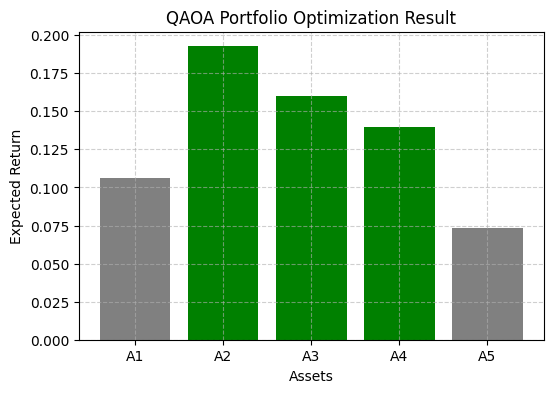

In [ ]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit_aer.primitives import Sampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer

# --- Step 1: Create Portfolio Data ---
np.random.seed(42)
n_assets = 5
expected_returns = np.random.uniform(0.05, 0.2, n_assets)
cov_matrix = np.random.rand(n_assets, n_assets)
cov_matrix = 0.1 * (cov_matrix + cov_matrix.T) / 2  # symmetric covariance

# Display data
df = pd.DataFrame({
    "Asset": [f"A{i+1}" for i in range(n_assets)],
    "Expected Return": expected_returns
})
print("Portfolio Data:")
print(df, "\n")
print("Covariance Matrix:\n", cov_matrix)

# --- Step 2: Build QUBO ---
qp = QuadraticProgram("portfolio_optimization")
for i in range(n_assets):
    qp.binary_var(name=f"x{i}")

risk_penalty = 0.5
linear = {f"x{i}": expected_returns[i] for i in range(n_assets)}
quadratic = {(f"x{i}", f"x{j}"): -risk_penalty * cov_matrix[i, j]
             for i in range(n_assets) for j in range(n_assets)}

qp.maximize(linear=linear, quadratic=quadratic)

# Choose only 3 assets
qp.linear_constraint(linear={f"x{i}": 1 for i in range(n_assets)},
                     sense="==", rhs=3, name="choose_3_assets")

print("\nQUBO Problem:")
print(qp.export_as_lp_string())

# --- Step 3: Solve using QAOA (modern syntax) ---
sampler = Sampler()
optimizer = COBYLA(maxiter=150)
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=2)
solver = MinimumEigenOptimizer(qaoa)

result = solver.solve(qp)

print("\nOptimal Solution:")
print(result)

# --- Step 4: Interpret Results ---
selected_assets = [f"A{i+1}" for i, x in enumerate(result.x) if x > 0.5]
print("\nSelected Assets:", selected_assets)

# --- Step 5: Visualization ---
plt.figure(figsize=(6, 4))
plt.bar(df["Asset"], df["Expected Return"],
        color=["green" if a in selected_assets else "gray" for a in df["Asset"]])
plt.title("QAOA Portfolio Optimization Result")
plt.xlabel("Assets")
plt.ylabel("Expected Return")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
